#For MNIST Dataset, meet 99.4%+ accuracy, but under the required parameters:i.e. <=20K and within 20 epochs)

In [1]:
from __future__ import print_function

''''from  __future__ import' statements can be used on *top-of* one's Python 
2.x code to enable new language features, that are not available in the older 
versions of Python. Esp. 'from __future__ import print_function' is a 
statement that one can use at the *top-of* the Python 2.x code to enable the 
print *function* from Python 3.x. In Python 2.x, the print *statement* is 
used to print to the standard output stream, whereas in Python 3.x, the print 
*function* is used. By using from __future__ import print_function, one can 
use the print *function* in the Python 2.x code, which can make it easier to 
port the code to Python 3.x in the future. '''
import torch

'''imports the torch module. This module provides functions for working with 
PyTorch, a popular open-source machine learning library for Python that is 
based on the Torch library used primarily for natural language processing and 
computer vision tasks. PyTorch provides a high-level interface for working 
with neural networks and allows users to perform complex operations on 
tensors with strong acceleration on many-core GPUs. '''
import torch.nn as nn

'''imports the torch.nn module (into the namespace nn by convention) from the 
torch package. This module provides a set of classes and functions that are 
commonly used to build and train neural networks in PyTorch. It contains 
classes for defining various types of layers in a neural network, as well as 
methods for forward propagation, backward propagation, and optimization. '''
import torch.nn.functional as F

'''imports torch.nn.functional module into the namespace F by convention. 
This module contains all the functions in the torch.nn library (whereas other 
parts of the library contain classes) and a wide range of loss and activation 
functions, one also finds here, some convenient functions for creating neural 
nets, such as pooling functions. '''
import torch.optim as optim

'''imports the torch.optim module from the torch package into the namespace 
optim. This module provides a set of classes and functions for 
*optimizing-the-parameters* of a neural network in PyTorch. It contains 
implementations of various optimization algorithms, such as stochastic 
gradient descent (SGD), Adam, and RMSprop. By importing the optim module and 
using the classes and functions it provides, one can *train-a-neural-network* 
in PyTorch by specifying the optimization algorithm and the network's 
parameters to optimize. '''

'''imports the datasets & transforms  modules from the torchvision package. 
The torchvision package is a popular library for working with image data in 
PyTorch. It contains a collection of functions and classes for loading, 
transforming, and analyzing image data. The *datasets module* provides 
classes for loading and organizing image data into datasets that can be 
easily used to train a neural network. The transforms module provides a set 
of common image transformations that can be applied to images in a dataset. 
These transformations include operations such as resizing, cropping, 
and normalizing the images. '''
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchsummary import summary
'''module is a progress bar library that is used to provide a visual indication
of the progress of a long-running operation in a Python script.'''
from tqdm import tqdm
%matplotlib inline
torch.cuda.manual_seed_all(1)
torch.manual_seed(1)
np.random.seed(1)

#### Following dscribes a step-by-step approach, taken to achieve the required goals (i.e. meeting 99.4%+ accuracy, but under the required parameters:i.e. <=20K and within 20 epochs) :
 
First of all, "fix up" the required architecture/layer-organization...in terms of choosing the number of kernels for each layer, followed a 'multiple-of-8' numbers (from 8, 16, 24, 32...etc):

### Architecture has 3 "components":
 
 1. One, separate initial,"image-conv2d" layer at the begining, to convolve over the "original image" channels, am initially providing 8 number of kernels for this 'separate' layer (which feeds in to the next  "block" of "2-conv2d-layers").Very important to note here that, 1 initial layer + The 2 following layers(of "2-conv2d-layer" "block") collectively provides a receptive field of 7x7 pixels(3->5->7) sufficient for extracting the MNIST datset's edges & gradient.This one is an "evolution"-experiment, where kernel numbers started out as 8 initially, but in the final architecture(which met the requirements) it became 16.
    
	
 2. conv2d-BLOCK with 2 layers (in this case):  This block will be placed after the first "image-conv2d" layer, and one more instance of this block, will    also follow the transition-block (explained below) later. In this evolution-experiment, kernel numbers initially started out as (8-16) for the 'first-2-layer-block' & (8-16) for the 'second-2-layer-block', but in the final architecture(which met the requirements) it became (16-16) for the 'first-2-layer-block' & (24-24) for the 'second-2-layer-block'.
    
    
 3. Transition Blocks: 1st transition layer, made up of 1. max-pool(k=2,s=2) and 2. a-1x1-feature-merger kernel, following the 'first-2-layer-block' &     2nd transition layer, towards the end (following the 2nd conv2d-block) which does NOT have the maxpool (i.e. just has one 1x1-feature-merger operator), and followed by the Global Average Pooling (GAP) layer leading upto the Softmax layer.    
    
### Architecture (i.e. in terms of channels used across individual layers):

    
    i.   "image-conv2d" layer: o/p initially 8 channels (becomes 16 in the final one)
    
    ii.  2 similar conv2d blocks, with:
    
              1st layer: (8-16) o/p channels (becomes (16-16) in the final one)
			 
              2nd layer: (8-16) o/p channels (becomes (24-24) in the final one)
	      
    iii. 1x1 conv2d for 2nd transition-layer: 10 o/p channels(for num-classes=10 digits)
    
 
Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|----------------------
`28x28x1`              | `(3x3x1)x8`   |      `26x26x8`  |      `3x3`|      
             |          `ReLU`  | 
**26x26x8**             | **(3x3x8)x8**  |      **24x24x8** |      **5x5**
             |          **ReLU**  |                 
**24x24x8**             | **(3x3x8)x16**  |      **22x22x16** |      **7x7**  
             |          **ReLU**  |                 
*22x22x16*             |   *MP(2x2)*    |      *11x11x16*   |      *14x14*                      
*11x11x16*             | *(1x1x16)x8*  |      *11x11x8*    |      *14x14* 
             |          *ReLU*  |     
**11x11x8**             | **(3x3x8)x8**  |      **9x9x8** |      **16x16** 
             |          **ReLU**  |       
**9x9x8**               | **(3x3x8)x16**  |      **7x7x16**  |      **18x18** 
             |          **ReLU**  |       
*7x7x16*               | *(1x1x16)x10*  |      *7x7x10*    |      *18x18*  (NO RELU at the o/p of this layer)    
7x7x10               | GAP  LAYER   |      1x10          |

 
       
    iv. At the end, following Architecture (same as the first-table above, 
    but with increased number of channels, like below is found to achieve 
    the required goal: 14,112 params, >99.4% accuracy, in less than 
    20 epochs 
        

Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|----------------------
`28x28x1`              | `(3x3x1)x16`   |      `26x26x16`  |      `3x3`
             |          `BN(16)`  |      
             |          `Dropout(3%)`  |      
             |          `ReLU`  |      
**26x26x16**             | **(3x3x16)x16**  |      **24x24x16** |      **5x5** 
             |          **BN(16)**  |      
             |          **Dropout(3%)**  |   
             |          **ReLU**  |                 
**24x24x16**             | **(3x3x16)x16**  |      **22x22x16** |      **7x7** 
             |          **BN(16)**  |      
             |          **Dropout(3%)**  |   
             |          **ReLU**  |                 
*22x22x16*             |   *MP(2x2)*    |      *11x11x16*   |      *14x14*                      
*11x11x16*             | *(1x1x16)x16*  |      *11x11x16*    |      *14x14*   
             |          *BN(16)*  |      
             |          *Dropout(3%)*  |  
             |          *ReLU*  |                 
**11x11x16**             | **(3x3x16)x24**  |      **9x9x24** |      **16x16**  
             |          **BN(24)**  |      
             |          **Dropout(3%)**  |    
             |          **ReLU**  |                 
**9x9x24**               | **(3x3x24)x24**  |      **7x7x24**  |      **18x18**   
             |          **BN(24)**  |      
             |          **Dropout(3%)**  |  
             |          **ReLU**  |                 
*7x7x24*               | *(1x1x24)x10*  |      *7x7x10*    |      *18x18*   (NO RELU at the o/p of this layer)   
7x7x10               | GAP  LAYER   |      1x10          |     

# First NW:

Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|----------------------
`28x28x1`              | `(3x3x1)x8`   |      `26x26x8`  |      `3x3`|      
             |          `ReLU`  | 
**26x26x8**             | **(3x3x8)x8**  |      **24x24x8** |      **5x5**
             |          **ReLU**  |                 
**24x24x8**             | **(3x3x8)x16**  |      **22x22x16** |      **7x7**  
             |          **ReLU**  |                 
*22x22x16*             |   *MP(2x2)*    |      *11x11x16*   |      *14x14*                      
*11x11x16*             | *(1x1x16)x8*  |      *11x11x8*    |      *14x14* 
             |          *ReLU*  |     
**11x11x8**             | **(3x3x8)x8**  |      **9x9x8** |      **16x16** 
             |          **ReLU**  |       
**9x9x8**               | **(3x3x8)x16**  |      **7x7x16**  |      **18x18** 
             |          **ReLU**  |       
*7x7x16*               | *(1x1x16)x10*  |      *7x7x10*    |      *18x18*  (NO RELU at the o/p of this layer)    
7x7x10               | GAP  LAYER   |      1x10          |

In [3]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, bias=False)#input:28x28x1, output:26x26x8, RF:3x3

        self.conv2 = nn.Conv2d(8, 8, 3, bias=False)#input:26x26x8, output:24x24x8, RF:5x5 
        self.conv3 = nn.Conv2d(8, 16, 3, bias=False)#input:24x24x8, output:22x22x16, RF:7x7

        self.pool1 = nn.MaxPool2d(2, 2)#input:22x22x16, output:11x11x16, RF:14x14  
        self.conv4 = nn.Conv2d(16, 8, 1, bias=False)#input:11x11x16, output:11x11x8, RF:14x14

        self.conv5 = nn.Conv2d(8, 8, 3, bias=False)#input:11x11x8, output:9x9x8, RF:16x16 
        self.conv6 = nn.Conv2d(8, 16, 3, bias=False)#input:9x9x8, output:7x7x16, RF:18x18

        self.conv7 = nn.Conv2d(16, 10, 1, bias=False)#input:7x7x16, output:7x7x10, RF:18x18
        self.gap1 = nn.AvgPool2d(kernel_size=7)#input:7x7x10, output:1x1x10 (or 1x10, 1-D data format now)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))# First Layer Separate
        x = F.relu(self.conv3(F.relu(self.conv2(x))))# First Block
        x = F.relu(self.conv4(self.pool1(x)))# first transition block
        x = F.relu(self.conv6(F.relu(self.conv5(x))))# Second Block 
        x = self.conv7(x)#no ReLU at 2nd Transition Block O/p(just 1x1, without a maxpool
        #towards the end here)leading to GAP & beyond) 
        x = self.gap1(x) # Global Average Pool layer
        x = x.view(-1, 10)#Num of classes = 10 (digits to be identified)
        return F.log_softmax(x, dim=1)

In [4]:
#!pip install torchsummary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model1 = Net1().to(device)
summary(model1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
            Conv2d-2            [-1, 8, 24, 24]             576
            Conv2d-3           [-1, 16, 22, 22]           1,152
         MaxPool2d-4           [-1, 16, 11, 11]               0
            Conv2d-5            [-1, 8, 11, 11]             128
            Conv2d-6              [-1, 8, 9, 9]             576
            Conv2d-7             [-1, 16, 7, 7]           1,152
            Conv2d-8             [-1, 10, 7, 7]             160
         AvgPool2d-9             [-1, 10, 1, 1]               0
Total params: 3,816
Trainable params: 3,816
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.01
Estimated Total Size (MB): 0.19
-----------------------------------------------

In [5]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [6]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_correct = 0
    acc=0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        pred_train = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_correct += pred_train.eq(target.view_as(pred_train)).sum().item()
        loss.backward()
        optimizer.step()
        pbar.set_description(desc=f'epoch={epoch} loss={loss.item()} batch_id={batch_idx}')
    train_loss = loss.item()
    acc = 100. * train_correct / len(train_loader.dataset)
    print('\nEpoch {}--Train set: Average loss: {:.4f}, Training Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))
    return acc, train_loss


def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    acc=0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print('\nEpoch {}--Test set: Average loss: {:.4f}, Validation Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return acc, test_loss

In [7]:
model1 = Net1().to(device)
optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
acc_history = []
loss_history = []
val_acc_history = []
val_loss_history = []
for epoch in range(1, 21):
    acc, train_loss = train(model1, device, train_loader, optimizer, epoch)
    val_acc, test_loss = test(model1, device, test_loader, epoch)
    acc_history.append(acc)
    loss_history.append(train_loss)
    val_acc_history.append(val_acc)
    val_loss_history.append(test_loss)

epoch=1 loss=1.5256381034851074 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.31it/s]


Epoch 1--Train set: Average loss: 1.5256, Training Accuracy: 7103/60000 (11.84%)




Epoch 1--Test set: Average loss: 1.7952, Validation Accuracy: 3662/10000 (36.62%)



epoch=2 loss=0.21838174760341644 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 45.88it/s]


Epoch 2--Train set: Average loss: 0.2184, Training Accuracy: 50841/60000 (84.73%)




Epoch 2--Test set: Average loss: 0.2152, Validation Accuracy: 9353/10000 (93.53%)



epoch=3 loss=0.3335224390029907 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 42.18it/s]


Epoch 3--Train set: Average loss: 0.3335, Training Accuracy: 55848/60000 (93.08%)




Epoch 3--Test set: Average loss: 0.1641, Validation Accuracy: 9516/10000 (95.16%)



epoch=4 loss=0.18622824549674988 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 45.92it/s]


Epoch 4--Train set: Average loss: 0.1862, Training Accuracy: 57001/60000 (95.00%)




Epoch 4--Test set: Average loss: 0.1381, Validation Accuracy: 9577/10000 (95.77%)



epoch=5 loss=0.059595637023448944 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.71it/s]



Epoch 5--Train set: Average loss: 0.0596, Training Accuracy: 57379/60000 (95.63%)


Epoch 5--Test set: Average loss: 0.1119, Validation Accuracy: 9662/10000 (96.62%)



epoch=6 loss=0.07748168706893921 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.57it/s]


Epoch 6--Train set: Average loss: 0.0775, Training Accuracy: 57737/60000 (96.23%)




Epoch 6--Test set: Average loss: 0.1343, Validation Accuracy: 9595/10000 (95.95%)



epoch=7 loss=0.07772501558065414 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 46.95it/s]


Epoch 7--Train set: Average loss: 0.0777, Training Accuracy: 57906/60000 (96.51%)




Epoch 7--Test set: Average loss: 0.0998, Validation Accuracy: 9700/10000 (97.00%)



epoch=8 loss=0.013627096079289913 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 42.13it/s]


Epoch 8--Train set: Average loss: 0.0136, Training Accuracy: 58145/60000 (96.91%)




Epoch 8--Test set: Average loss: 0.1012, Validation Accuracy: 9697/10000 (96.97%)



epoch=9 loss=0.0323362872004509 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.48it/s]


Epoch 9--Train set: Average loss: 0.0323, Training Accuracy: 58223/60000 (97.04%)




Epoch 9--Test set: Average loss: 0.1177, Validation Accuracy: 9638/10000 (96.38%)



epoch=10 loss=0.05434206873178482 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.61it/s]



Epoch 10--Train set: Average loss: 0.0543, Training Accuracy: 58342/60000 (97.24%)


Epoch 10--Test set: Average loss: 0.0863, Validation Accuracy: 9734/10000 (97.34%)



epoch=11 loss=0.1182275339961052 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.03it/s]


Epoch 11--Train set: Average loss: 0.1182, Training Accuracy: 58424/60000 (97.37%)




Epoch 11--Test set: Average loss: 0.0893, Validation Accuracy: 9735/10000 (97.35%)



epoch=12 loss=0.021401813253760338 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 45.51it/s]


Epoch 12--Train set: Average loss: 0.0214, Training Accuracy: 58525/60000 (97.54%)




Epoch 12--Test set: Average loss: 0.0745, Validation Accuracy: 9758/10000 (97.58%)



epoch=13 loss=0.10001946240663528 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 46.98it/s]


Epoch 13--Train set: Average loss: 0.1000, Training Accuracy: 58560/60000 (97.60%)




Epoch 13--Test set: Average loss: 0.0830, Validation Accuracy: 9751/10000 (97.51%)



epoch=14 loss=0.010474154725670815 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.03it/s]


Epoch 14--Train set: Average loss: 0.0105, Training Accuracy: 58604/60000 (97.67%)




Epoch 14--Test set: Average loss: 0.0702, Validation Accuracy: 9777/10000 (97.77%)



epoch=15 loss=0.021085279062390327 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.22it/s]


Epoch 15--Train set: Average loss: 0.0211, Training Accuracy: 58686/60000 (97.81%)




Epoch 15--Test set: Average loss: 0.0711, Validation Accuracy: 9773/10000 (97.73%)



epoch=16 loss=0.043340492993593216 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.75it/s]


Epoch 16--Train set: Average loss: 0.0433, Training Accuracy: 58736/60000 (97.89%)




Epoch 16--Test set: Average loss: 0.0621, Validation Accuracy: 9801/10000 (98.01%)



epoch=17 loss=0.005657188128679991 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.34it/s]


Epoch 17--Train set: Average loss: 0.0057, Training Accuracy: 58786/60000 (97.98%)




Epoch 17--Test set: Average loss: 0.0659, Validation Accuracy: 9784/10000 (97.84%)



epoch=18 loss=0.10739366710186005 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.70it/s]


Epoch 18--Train set: Average loss: 0.1074, Training Accuracy: 58832/60000 (98.05%)




Epoch 18--Test set: Average loss: 0.0624, Validation Accuracy: 9814/10000 (98.14%)



epoch=19 loss=0.07735539227724075 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.87it/s]


Epoch 19--Train set: Average loss: 0.0774, Training Accuracy: 58780/60000 (97.97%)




Epoch 19--Test set: Average loss: 0.0683, Validation Accuracy: 9785/10000 (97.85%)



epoch=20 loss=0.18197119235992432 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.83it/s]



Epoch 20--Train set: Average loss: 0.1820, Training Accuracy: 58862/60000 (98.10%)


Epoch 20--Test set: Average loss: 0.0541, Validation Accuracy: 9816/10000 (98.16%)



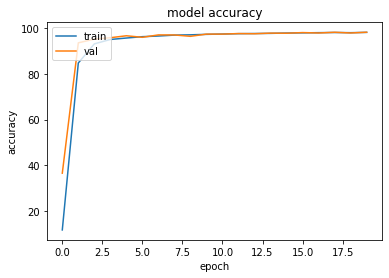

In [8]:
_= plt.plot(acc_history)
_= plt.plot(val_acc_history)
_= plt.title('model accuracy')
_= plt.ylabel('accuracy')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

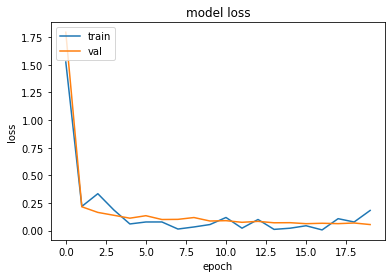

In [9]:
_= plt.plot(loss_history)
_= plt.plot(val_loss_history)
_= plt.title('model loss')
_= plt.ylabel('loss')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

- First observation: with total 3,816 parameters, the max validation accuracy reached: ~98.16%

- The logs and accuracy plot above show that there is some overfitting in terms of the accuracy plot, that the train and test accuracies seem to be running in close step/embrace. With not much "potential" for the test/validation accuracy to increase, with a corresponding increase in training accuracy.

- Additionally, with required 20 epochs, the "network capacity" seems to be NOT sufficient to meet the goal.

- But, despite an urgent need for "capacity-boost" thru increased channels, we would STILL like to see, if with an "incremental" addition of Batch-Norm, Dropout, what extra effects/benefits or disadvantages could be seen? 


#2nd NW: added just the Batch Normalization at each layer(we should expect some increase in accuracy in this case)

Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|----------------------
`28x28x1`              | `(3x3x1)x8`   |      `26x26x8`  |      `3x3`| 
             |          `BN(8)`  |   
             |          `ReLU`  | 
**26x26x8**             | **(3x3x8)x8**  |      **24x24x8** |      **5x5**
             |          **BN(8)**  |   
             |          **ReLU**  |                 
**24x24x8**             | **(3x3x8)x16**  |      **22x22x16** |      **7x7** 
             |          **BN(16)**  |  
             |          **ReLU**  |                 
*22x22x16*             |   *MP(2x2)*    |      *11x11x16*   |      *14x14*                      
*11x11x16*             | *(1x1x16)x8*  |      *11x11x8*    |      *14x14* 
             |          *BN(8)*  |  
             |          *ReLU*  |     
**11x11x8**             | **(3x3x8)x8**  |      **9x9x8** |      **16x16** 
             |          **BN(8)**  |  
             |          **ReLU**  |       
**9x9x8**               | **(3x3x8)x16**  |      **7x7x16**  |      **18x18** 
             |          **BN(16)**  |  
             |          **ReLU**  |       
*7x7x16*               | *(1x1x16)x10*  |      *7x7x10*    |      *18x18*  (NO RELU at the o/p of this layer)    
7x7x10               | GAP  LAYER   |      1x10          |

In [2]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, bias=False)#input:28x28x1, output:26x26x8, RF:3x3
        self.conv1_bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 8, 3, bias=False)#input:26x26x8, output:24x24x8, RF:5x5 
        self.conv2_bn2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 16, 3, bias=False)#input:24x24x8, output:22x22x16, RF:7x7
        self.conv3_bn3 = nn.BatchNorm2d(16)

        self.pool1 = nn.MaxPool2d(2, 2)#input:22x22x16, output:11x11x16, RF:14x14  
        self.conv4 = nn.Conv2d(16, 8, 1, bias=False)#input:11x11x16, output:11x11x8, RF:14x14
        self.conv4_bn4 = nn.BatchNorm2d(8)

        self.conv5 = nn.Conv2d(8, 8, 3, bias=False)#input:11x11x8, output:9x9x8, RF:16x16 
        self.conv5_bn5 = nn.BatchNorm2d(8)
        self.conv6 = nn.Conv2d(8, 16, 3, bias=False)#input:9x9x8, output:7x7x16, RF:18x18
        self.conv6_bn6 = nn.BatchNorm2d(16)

        self.conv7 = nn.Conv2d(16, 10, 1, bias=False)#input:7x7x16, output:7x7x10, RF:18x18
        self.gap1 = nn.AvgPool2d(kernel_size=7)#input:7x7x10, output:1x1x10 (or 1x10, 1-D data format now)
        
    def forward(self, x):
        x = F.relu(self.conv1_bn1(self.conv1(x)))# First Layer Separate
        x = F.relu(self.conv3_bn3(self.conv3(F.relu(self.conv2_bn2(self.conv2(x))))))# First Block
        x = F.relu(self.conv4_bn4(self.conv4(self.pool1(x))))# first transition block
        x = F.relu(self.conv6_bn6(self.conv6(F.relu(self.conv5_bn5(self.conv5(x))))))# Second Block 
        x = self.conv7(x)#there is no ReLU at this 1x1 operator's O/p, leading to GAP & beyond 
        x = self.gap1(x) # Global Average Pool layer
        x = x.view(-1, 10)#Num of classes = 10 (digits to be identified)
        return F.log_softmax(x, dim=1)

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model2 = Net2().to(device)
summary(model2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
            Conv2d-3            [-1, 8, 24, 24]             576
       BatchNorm2d-4            [-1, 8, 24, 24]              16
            Conv2d-5           [-1, 16, 22, 22]           1,152
       BatchNorm2d-6           [-1, 16, 22, 22]              32
         MaxPool2d-7           [-1, 16, 11, 11]               0
            Conv2d-8            [-1, 8, 11, 11]             128
       BatchNorm2d-9            [-1, 8, 11, 11]              16
           Conv2d-10              [-1, 8, 9, 9]             576
      BatchNorm2d-11              [-1, 8, 9, 9]              16
           Conv2d-12             [-1, 16, 7, 7]           1,152
      BatchNorm2d-13             [-1, 16, 7, 7]              32
           Conv2d-14             [-1, 1

In [4]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [5]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_correct = 0
    acc=0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        pred_train = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_correct += pred_train.eq(target.view_as(pred_train)).sum().item()
        loss.backward()
        optimizer.step()
        pbar.set_description(desc=f'epoch={epoch} loss={loss.item()} batch_id={batch_idx}')
    train_loss = loss.item()
    acc = 100. * train_correct / len(train_loader.dataset)
    print('\nEpoch {}--Train set: Average loss: {:.4f}, Training Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))
    return acc, train_loss


def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    acc=0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print('\nEpoch {}--Test set: Average loss: {:.4f}, Validation Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return acc, test_loss

In [6]:
model2 = Net2().to(device)
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
acc_history = []
loss_history = []
val_acc_history = []
val_loss_history = []
for epoch in range(1, 21):
    acc, train_loss = train(model2, device, train_loader, optimizer, epoch)
    val_acc, test_loss = test(model2, device, test_loader, epoch)
    acc_history.append(acc)
    loss_history.append(train_loss)
    val_acc_history.append(val_acc)
    val_loss_history.append(test_loss)

epoch=1 loss=0.2425346076488495 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 40.66it/s]


Epoch 1--Train set: Average loss: 0.2425, Training Accuracy: 50214/60000 (83.69%)




Epoch 1--Test set: Average loss: 0.1446, Validation Accuracy: 9654/10000 (96.54%)



epoch=2 loss=0.0702226534485817 batch_id=937: 100%|██████████| 938/938 [00:21<00:00, 43.26it/s]


Epoch 2--Train set: Average loss: 0.0702, Training Accuracy: 58037/60000 (96.73%)




Epoch 2--Test set: Average loss: 0.1260, Validation Accuracy: 9645/10000 (96.45%)



epoch=3 loss=0.10387763381004333 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 44.96it/s]


Epoch 3--Train set: Average loss: 0.1039, Training Accuracy: 58503/60000 (97.50%)




Epoch 3--Test set: Average loss: 0.0843, Validation Accuracy: 9764/10000 (97.64%)



epoch=4 loss=0.028218435123562813 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 44.91it/s]


Epoch 4--Train set: Average loss: 0.0282, Training Accuracy: 58689/60000 (97.81%)




Epoch 4--Test set: Average loss: 0.0735, Validation Accuracy: 9779/10000 (97.79%)



epoch=5 loss=0.17054538428783417 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 40.48it/s]


Epoch 5--Train set: Average loss: 0.1705, Training Accuracy: 58815/60000 (98.03%)




Epoch 5--Test set: Average loss: 0.0639, Validation Accuracy: 9821/10000 (98.21%)



epoch=6 loss=0.016321348026394844 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 41.70it/s]


Epoch 6--Train set: Average loss: 0.0163, Training Accuracy: 58942/60000 (98.24%)




Epoch 6--Test set: Average loss: 0.0549, Validation Accuracy: 9825/10000 (98.25%)



epoch=7 loss=0.015870360657572746 batch_id=937: 100%|██████████| 938/938 [00:21<00:00, 43.17it/s]


Epoch 7--Train set: Average loss: 0.0159, Training Accuracy: 59017/60000 (98.36%)




Epoch 7--Test set: Average loss: 0.0534, Validation Accuracy: 9834/10000 (98.34%)



epoch=8 loss=0.01618575118482113 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 40.58it/s]


Epoch 8--Train set: Average loss: 0.0162, Training Accuracy: 59069/60000 (98.45%)




Epoch 8--Test set: Average loss: 0.0473, Validation Accuracy: 9865/10000 (98.65%)



epoch=9 loss=0.026916181668639183 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 39.62it/s]


Epoch 9--Train set: Average loss: 0.0269, Training Accuracy: 59106/60000 (98.51%)




Epoch 9--Test set: Average loss: 0.0533, Validation Accuracy: 9832/10000 (98.32%)



epoch=10 loss=0.028154082596302032 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 45.40it/s]


Epoch 10--Train set: Average loss: 0.0282, Training Accuracy: 59176/60000 (98.63%)




Epoch 10--Test set: Average loss: 0.0431, Validation Accuracy: 9857/10000 (98.57%)



epoch=11 loss=0.02262197434902191 batch_id=937: 100%|██████████| 938/938 [00:24<00:00, 38.93it/s]


Epoch 11--Train set: Average loss: 0.0226, Training Accuracy: 59233/60000 (98.72%)




Epoch 11--Test set: Average loss: 0.0400, Validation Accuracy: 9876/10000 (98.76%)



epoch=12 loss=0.06976579874753952 batch_id=937: 100%|██████████| 938/938 [00:25<00:00, 37.34it/s]


Epoch 12--Train set: Average loss: 0.0698, Training Accuracy: 59213/60000 (98.69%)




Epoch 12--Test set: Average loss: 0.0431, Validation Accuracy: 9873/10000 (98.73%)



epoch=13 loss=0.07526052743196487 batch_id=937: 100%|██████████| 938/938 [00:25<00:00, 37.27it/s]


Epoch 13--Train set: Average loss: 0.0753, Training Accuracy: 59299/60000 (98.83%)




Epoch 13--Test set: Average loss: 0.0427, Validation Accuracy: 9851/10000 (98.51%)



epoch=14 loss=0.011611970141530037 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 40.81it/s]


Epoch 14--Train set: Average loss: 0.0116, Training Accuracy: 59296/60000 (98.83%)




Epoch 14--Test set: Average loss: 0.0441, Validation Accuracy: 9870/10000 (98.70%)



epoch=15 loss=0.006371391471475363 batch_id=937: 100%|██████████| 938/938 [00:21<00:00, 44.06it/s]


Epoch 15--Train set: Average loss: 0.0064, Training Accuracy: 59332/60000 (98.89%)




Epoch 15--Test set: Average loss: 0.0351, Validation Accuracy: 9894/10000 (98.94%)



epoch=16 loss=0.020515767857432365 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 42.33it/s]


Epoch 16--Train set: Average loss: 0.0205, Training Accuracy: 59346/60000 (98.91%)




Epoch 16--Test set: Average loss: 0.0435, Validation Accuracy: 9864/10000 (98.64%)



epoch=17 loss=0.07055173814296722 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 42.03it/s]


Epoch 17--Train set: Average loss: 0.0706, Training Accuracy: 59355/60000 (98.92%)




Epoch 17--Test set: Average loss: 0.0363, Validation Accuracy: 9887/10000 (98.87%)



epoch=18 loss=0.18313534557819366 batch_id=937: 100%|██████████| 938/938 [00:24<00:00, 38.46it/s]


Epoch 18--Train set: Average loss: 0.1831, Training Accuracy: 59398/60000 (99.00%)




Epoch 18--Test set: Average loss: 0.0461, Validation Accuracy: 9858/10000 (98.58%)



epoch=19 loss=0.027960361912846565 batch_id=937: 100%|██████████| 938/938 [00:24<00:00, 38.82it/s]


Epoch 19--Train set: Average loss: 0.0280, Training Accuracy: 59372/60000 (98.95%)




Epoch 19--Test set: Average loss: 0.0369, Validation Accuracy: 9874/10000 (98.74%)



epoch=20 loss=0.13993312418460846 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 45.03it/s]


Epoch 20--Train set: Average loss: 0.1399, Training Accuracy: 59396/60000 (98.99%)




Epoch 20--Test set: Average loss: 0.0313, Validation Accuracy: 9895/10000 (98.95%)



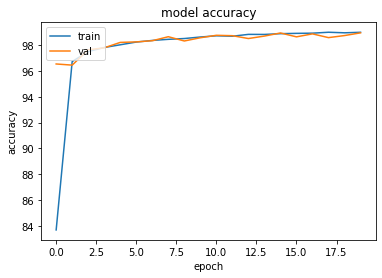

In [7]:
_= plt.plot(acc_history)
_= plt.plot(val_acc_history)
_= plt.title('model accuracy')
_= plt.ylabel('accuracy')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

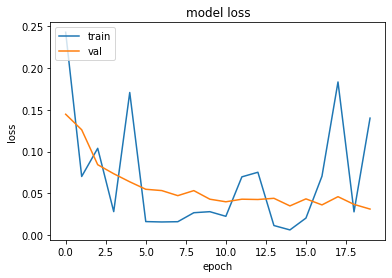

In [8]:
_= plt.plot(loss_history)
_= plt.plot(val_loss_history)
_= plt.title('model loss')
_= plt.ylabel('loss')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

- Total params: 3,944 (which is expectedly, higher as compared to the 1st NW) & the max validation accuracy reaches: ~98.95%
- we got little better in terms of the reached accuracy  but expectedly, far from the required accuracy goal.
- Also in terms of the accuracy plot & logs, we could see that the further potential for increase for the validation accuracy has not yet opened up (it is still overfitting...i.e. the training accuracy has reached 99.0% but the validation acuracy still under ~98.95%, hence not much scope for further increase, with a corresponding increase in training accuracy )
- just like the earlier NW, this one can't meet the goal within the required 20 epochs(capacity boost definitely required)

### 3rd NW: added Dropout as well, at each layer, apart from the BN(we should expect lesser overfitting  i.e an increase in the "potential" to increase validation accuracy with a corresponding increase in training-accuracy) i.e. a gap opening up (it was viewed, that a value of 3% for Dropout was giving a better results as compared to other test-ranges from 1-10%)

Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|----------------------
`28x28x1`              | `(3x3x1)x8`   |      `26x26x8`  |      `3x3`| 
             |          `BN(8)`  | 
             |          `Dropout(3%)`  |                
             |          `ReLU`  | 
**26x26x8**             | **(3x3x8)x8**  |      **24x24x8** |      **5x5**
             |          **BN(8)**  | 
             |          **Dropout(3%)** |                
             |          **ReLU**  |                 
**24x24x8**             | **(3x3x8)x16**  |      **22x22x16** |      **7x7** 
             |          **BN(16)**  | 
             |          **Dropout(3%)** |              
             |          **ReLU**  |                 
*22x22x16*             |   *MP(2x2)*    |      *11x11x16*   |      *14x14*                      
*11x11x16*             | *(1x1x16)x8*  |      *11x11x8*    |      *14x14* 
             |          *BN(8)*  |  
             |          *Dropout(3%)* |              
             |          *ReLU*  |     
**11x11x8**             | **(3x3x8)x8**  |      **9x9x8** |      **16x16** 
             |          **BN(8)**  | 
             |          **Dropout(3%)** |             
             |          **ReLU**  |       
**9x9x8**               | **(3x3x8)x16**  |      **7x7x16**  |      **18x18** 
             |          **BN(16)**  |  
             |          **Dropout(3%)** |             
             |          **ReLU**  |       
*7x7x16*               | *(1x1x16)x10*  |      *7x7x10*    |      *18x18*  (NO RELU at the o/p of this layer)    
7x7x10               | GAP  LAYER   |      1x10          |

In [2]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, bias=False)#input:28x28x1, output:26x26x8, RF:3x3
        self.conv1_bn1 = nn.BatchNorm2d(8)
        self.conv1_drop1 = nn.Dropout2d(0.03)

        self.conv2 = nn.Conv2d(8, 8, 3, bias=False)#input:26x26x8, output:24x24x8, RF:5x5 
        self.conv2_bn2 = nn.BatchNorm2d(8)
        self.conv2_drop2 = nn.Dropout2d(0.03)
        self.conv3 = nn.Conv2d(8, 16, 3, bias=False)#input:24x24x8, output:22x22x16, RF:7x7
        self.conv3_bn3 = nn.BatchNorm2d(16)
        self.conv3_drop3 = nn.Dropout2d(0.03)

        self.pool1 = nn.MaxPool2d(2, 2)#input:22x22x16, output:11x11x16, RF:14x14  
        self.conv4 = nn.Conv2d(16, 8, 1, bias=False)#input:11x11x16, output:11x11x8, RF:14x14
        self.conv4_bn4 = nn.BatchNorm2d(8)
        self.conv4_drop4 = nn.Dropout2d(0.03)

        self.conv5 = nn.Conv2d(8, 8, 3, bias=False)#input:11x11x8, output:9x9x8, RF:16x16 
        self.conv5_bn5 = nn.BatchNorm2d(8)
        self.conv5_drop5 = nn.Dropout2d(0.03)
        self.conv6 = nn.Conv2d(8, 16, 3, bias=False)#input:9x9x8, output:7x7x16, RF:18x18
        self.conv6_bn6 = nn.BatchNorm2d(16)
        self.conv6_drop6 = nn.Dropout2d(0.03)

        self.conv7 = nn.Conv2d(16, 10, 1, bias=False)#input:7x7x16, output:7x7x10, RF:18x18
        self.gap1 = nn.AvgPool2d(kernel_size=7)#input:7x7x10, output:1x1x10 (or 1x10, 1-D data format now)
        
    def forward(self, x):
        x = F.relu(self.conv1_drop1(self.conv1_bn1(self.conv1(x))))# First Layer Separate
        x = F.relu(self.conv3_drop3(self.conv3_bn3(self.conv3(F.relu(self.conv2_drop2(self.conv2_bn2(self.conv2(x))))))))# First Block
        x = F.relu(self.conv4_drop4(self.conv4_bn4(self.conv4(self.pool1(x)))))# first transition block
        x = F.relu(self.conv6_drop6(self.conv6_bn6(self.conv6(F.relu(self.conv5_drop5(self.conv5_bn5(self.conv5(x))))))))# Second Block 
        x = self.conv7(x)#no ReLU at 2nd Transition Block O/p(without a maxpool towards the end here)leading to GAP & beyond) 
        x = self.gap1(x) # Global Average Pool layer
        x = x.view(-1, 10)#Num of classes = 10 (digits to be identified)
        return F.log_softmax(x, dim=1)

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model3 = Net3().to(device)
summary(model3, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
         Dropout2d-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             576
       BatchNorm2d-5            [-1, 8, 24, 24]              16
         Dropout2d-6            [-1, 8, 24, 24]               0
            Conv2d-7           [-1, 16, 22, 22]           1,152
       BatchNorm2d-8           [-1, 16, 22, 22]              32
         Dropout2d-9           [-1, 16, 22, 22]               0
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11            [-1, 8, 11, 11]             128
      BatchNorm2d-12            [-1, 8, 11, 11]              16
        Dropout2d-13            [-1, 8, 11, 11]               0
           Conv2d-14              [-1, 

In [4]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [5]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_correct = 0
    acc=0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        pred_train = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_correct += pred_train.eq(target.view_as(pred_train)).sum().item()
        loss.backward()
        optimizer.step()
        pbar.set_description(desc=f'epoch={epoch} loss={loss.item()} batch_id={batch_idx}')
    train_loss = loss.item()
    acc = 100. * train_correct / len(train_loader.dataset)
    print('\nEpoch {}--Train set: Average loss: {:.4f}, Training Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))
    return acc, train_loss


def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    acc=0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print('\nEpoch {}--Test set: Average loss: {:.4f}, Validation Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return acc, test_loss

In [6]:
model3 = Net3().to(device)
optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
acc_history = []
loss_history = []
val_acc_history = []
val_loss_history = []
for epoch in range(1, 21):
    acc, train_loss = train(model3, device, train_loader, optimizer, epoch)
    val_acc, test_loss = test(model3, device, test_loader, epoch)
    acc_history.append(acc)
    loss_history.append(train_loss)
    val_acc_history.append(val_acc)
    val_loss_history.append(test_loss)

epoch=1 loss=0.5631867051124573 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]


Epoch 1--Train set: Average loss: 0.5632, Training Accuracy: 36721/60000 (61.20%)




Epoch 1--Test set: Average loss: 0.4238, Validation Accuracy: 9218/10000 (92.18%)



epoch=2 loss=0.2942626178264618 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.71it/s]


Epoch 2--Train set: Average loss: 0.2943, Training Accuracy: 52829/60000 (88.05%)




Epoch 2--Test set: Average loss: 0.1867, Validation Accuracy: 9598/10000 (95.98%)



epoch=3 loss=0.38592734932899475 batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 27.56it/s]


Epoch 3--Train set: Average loss: 0.3859, Training Accuracy: 54746/60000 (91.24%)




Epoch 3--Test set: Average loss: 0.1294, Validation Accuracy: 9692/10000 (96.92%)



epoch=4 loss=0.28506267070770264 batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 26.22it/s]


Epoch 4--Train set: Average loss: 0.2851, Training Accuracy: 55438/60000 (92.40%)




Epoch 4--Test set: Average loss: 0.1095, Validation Accuracy: 9723/10000 (97.23%)



epoch=5 loss=0.19444626569747925 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s]


Epoch 5--Train set: Average loss: 0.1944, Training Accuracy: 55837/60000 (93.06%)




Epoch 5--Test set: Average loss: 0.1032, Validation Accuracy: 9721/10000 (97.21%)



epoch=6 loss=0.14052428305149078 batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 26.64it/s]


Epoch 6--Train set: Average loss: 0.1405, Training Accuracy: 56269/60000 (93.78%)




Epoch 6--Test set: Average loss: 0.0882, Validation Accuracy: 9737/10000 (97.37%)



epoch=7 loss=0.1437220275402069 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.04it/s]



Epoch 7--Train set: Average loss: 0.1437, Training Accuracy: 56450/60000 (94.08%)


Epoch 7--Test set: Average loss: 0.0769, Validation Accuracy: 9790/10000 (97.90%)



epoch=8 loss=0.083974190056324 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.12it/s]


Epoch 8--Train set: Average loss: 0.0840, Training Accuracy: 56661/60000 (94.44%)




Epoch 8--Test set: Average loss: 0.0815, Validation Accuracy: 9773/10000 (97.73%)



epoch=9 loss=0.18960857391357422 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]


Epoch 9--Train set: Average loss: 0.1896, Training Accuracy: 56808/60000 (94.68%)




Epoch 9--Test set: Average loss: 0.0727, Validation Accuracy: 9787/10000 (97.87%)



epoch=10 loss=0.13071712851524353 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.25it/s]



Epoch 10--Train set: Average loss: 0.1307, Training Accuracy: 56998/60000 (95.00%)


Epoch 10--Test set: Average loss: 0.0743, Validation Accuracy: 9785/10000 (97.85%)



epoch=11 loss=0.171994149684906 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]



Epoch 11--Train set: Average loss: 0.1720, Training Accuracy: 56938/60000 (94.90%)


Epoch 11--Test set: Average loss: 0.0663, Validation Accuracy: 9799/10000 (97.99%)



epoch=12 loss=0.2009219080209732 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.45it/s]


Epoch 12--Train set: Average loss: 0.2009, Training Accuracy: 57123/60000 (95.20%)




Epoch 12--Test set: Average loss: 0.0610, Validation Accuracy: 9821/10000 (98.21%)



epoch=13 loss=0.28060898184776306 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.78it/s]


Epoch 13--Train set: Average loss: 0.2806, Training Accuracy: 57197/60000 (95.33%)




Epoch 13--Test set: Average loss: 0.0607, Validation Accuracy: 9813/10000 (98.13%)



epoch=14 loss=0.11809297651052475 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.43it/s]


Epoch 14--Train set: Average loss: 0.1181, Training Accuracy: 57312/60000 (95.52%)




Epoch 14--Test set: Average loss: 0.0604, Validation Accuracy: 9816/10000 (98.16%)



epoch=15 loss=0.2706768214702606 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.45it/s]


Epoch 15--Train set: Average loss: 0.2707, Training Accuracy: 57283/60000 (95.47%)




Epoch 15--Test set: Average loss: 0.0589, Validation Accuracy: 9818/10000 (98.18%)



epoch=16 loss=0.24039588868618011 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.06it/s]


Epoch 16--Train set: Average loss: 0.2404, Training Accuracy: 57416/60000 (95.69%)




Epoch 16--Test set: Average loss: 0.0590, Validation Accuracy: 9824/10000 (98.24%)



epoch=17 loss=0.0910857692360878 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.75it/s]


Epoch 17--Train set: Average loss: 0.0911, Training Accuracy: 57487/60000 (95.81%)




Epoch 17--Test set: Average loss: 0.0560, Validation Accuracy: 9834/10000 (98.34%)



epoch=18 loss=0.12371215969324112 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]


Epoch 18--Train set: Average loss: 0.1237, Training Accuracy: 57521/60000 (95.87%)




Epoch 18--Test set: Average loss: 0.0563, Validation Accuracy: 9830/10000 (98.30%)



epoch=19 loss=0.14391116797924042 batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 27.36it/s]


Epoch 19--Train set: Average loss: 0.1439, Training Accuracy: 57528/60000 (95.88%)




Epoch 19--Test set: Average loss: 0.0530, Validation Accuracy: 9839/10000 (98.39%)



epoch=20 loss=0.17988546192646027 batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 27.44it/s]


Epoch 20--Train set: Average loss: 0.1799, Training Accuracy: 57617/60000 (96.03%)




Epoch 20--Test set: Average loss: 0.0555, Validation Accuracy: 9836/10000 (98.36%)



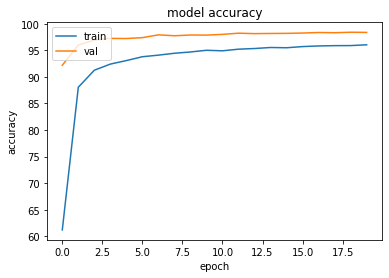

In [7]:
_= plt.plot(acc_history)
_= plt.plot(val_acc_history)
_= plt.title('model accuracy')
_= plt.ylabel('accuracy')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

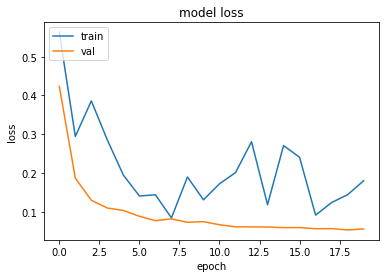

In [8]:
_= plt.plot(loss_history)
_= plt.plot(val_loss_history)
_= plt.title('model loss')
_= plt.ylabel('loss')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

- Total params: 3,944 (which is expectedly,same as compared to the last NW as dropout doesn't add params) & the max validation accuracy reaches: ~98.39% (though this seems almost comparable to the achieved max in last iteration, but in case of adding Dropout, we have considerably overcome the overfitting issue, by opening up the gap between training and test accuracies...i.e. now we can see that the test accuracy value like ~98% is achieved while the training accuracy is still at ~96%, which has opened up the potential for further increase in the validation accuracy, given we have a required number of epochs and NW-capacity with us.

- Also in terms of the accuracy plot, both the train and test accuracies seem to be maintaining almost consistent gap (training accuracy growth is looking stagnant though, but some scope is open)

- As a final step for this architecture-option we are required to the given Learning rate value hence that aspect won't be explored further.

- But to achieve the required goal we will have to go for a capacity increase now, the next iteration tries to do the same.

### 4th NW: while retaining the same template for the Batch Normalization, Dropout and layering, we now increase the channels to follow the layering as given ahead(it was viewed, that a value of 3% for Dropout was giving a better results as compared to other test-ranges from 1-10%) "|16|--|16-16|--|Transition|--|24-24|--|Transition|--|GAP|--|softmax-classifier|" as in the table below

Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|----------------------
`28x28x1`              | `(3x3x1)x16`   |      `26x26x16`  |      `3x3`
             |          `BN(16)`  |      
             |          `Dropout(3%)`  |      
             |          `ReLU`  |      
**26x26x16**             | **(3x3x16)x16**  |      **24x24x16** |      **5x5** 
             |          **BN(16)**  |      
             |          **Dropout(3%)**  |   
             |          **ReLU**  |                 
**24x24x16**             | **(3x3x16)x16**  |      **22x22x16** |      **7x7** 
             |          **BN(16)**  |      
             |          **Dropout(3%)**  |   
             |          **ReLU**  |                 
*22x22x16*             |   *MP(2x2)*    |      *11x11x16*   |      *14x14*                      
*11x11x16*             | *(1x1x16)x16*  |      *11x11x16*    |      *14x14*   
             |          *BN(16)*  |      
             |          *Dropout(3%)*  |  
             |          *ReLU*  |                 
**11x11x16**             | **(3x3x16)x24**  |      **9x9x24** |      **16x16**  
             |          **BN(24)**  |      
             |          **Dropout(3%)**  |    
             |          **ReLU**  |                 
**9x9x24**               | **(3x3x24)x24**  |      **7x7x24**  |      **18x18**   
             |          **BN(24)**  |      
             |          **Dropout(3%)**  |  
             |          **ReLU**  |                 
*7x7x24*               | *(1x1x24)x10*  |      *7x7x10*    |      *18x18*  (NO RELU at the o/p of this layer)     
7x7x10               | GAP  LAYER   |      1x10          |     

In [2]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, bias=False)#input:28x28x1, output:26x26x16, RF:3x3
        self.conv1_bn1 = nn.BatchNorm2d(16)
        self.conv1_drop1 = nn.Dropout2d(0.03)

        self.conv2 = nn.Conv2d(16, 16, 3, bias=False)#input:26x26x16, output:24x24x16, RF:5x5 
        self.conv2_bn2 = nn.BatchNorm2d(16)
        self.conv2_drop2 = nn.Dropout2d(0.03)
        self.conv3 = nn.Conv2d(16, 16, 3, bias=False)#input:24x24x16, output:22x22x16, RF:7x7
        self.conv3_bn3 = nn.BatchNorm2d(16)
        self.conv3_drop3 = nn.Dropout2d(0.03)

        self.pool1 = nn.MaxPool2d(2, 2)#input:22x22x16, output:11x11x16, RF:14x14  
        self.conv4 = nn.Conv2d(16, 16, 1, bias=False)#input:11x11x16, output:11x11x16, RF:14x14
        self.conv4_bn4 = nn.BatchNorm2d(16)
        self.conv4_drop4 = nn.Dropout2d(0.03)

        self.conv5 = nn.Conv2d(16, 24, 3, bias=False)#input:11x11x16, output:9x9x24, RF:16x16 
        self.conv5_bn5 = nn.BatchNorm2d(24)
        self.conv5_drop5 = nn.Dropout2d(0.03)
        self.conv6 = nn.Conv2d(24, 24, 3, bias=False)#input:9x9x24, output:7x7x24, RF:18x18
        self.conv6_bn6 = nn.BatchNorm2d(24)
        self.conv6_drop6 = nn.Dropout2d(0.03)
        
        self.conv7 = nn.Conv2d(24, 10, 1, bias=False)#input:7x7x24, output:7x7x10, RF:18x18
        self.gap1 = nn.AvgPool2d(kernel_size=7)#input:7x7x10, output:1x1x10 (or 1x10, 1-D data format now)
        
    def forward(self, x):
        x = F.relu(self.conv1_drop1(self.conv1_bn1(self.conv1(x))))#First Layer Separate
        x = F.relu(self.conv3_drop3(self.conv3_bn3(self.conv3(F.relu(self.conv2_drop2(self.conv2_bn2(self.conv2(x))))))))#First Block
        x = F.relu(self.conv4_drop4(self.conv4_bn4(self.conv4(self.pool1(x)))))#First transition block
        x = F.relu(self.conv6_drop6(self.conv6_bn6(self.conv6(F.relu(self.conv5_drop5(self.conv5_bn5(self.conv5(x))))))))#Second Block 
        x = self.conv7(x)#no ReLU at 2nd Transition Block O/p(just 1x1, without a maxpool towards the end here)leading to GAP & beyond) 
        x = self.gap1(x) # Global Average Pool layer
        x = x.view(-1, 10)#Num of classes = 10 (digits to be identified)
        return F.log_softmax(x, dim=1)

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model4 = Net4().to(device)
summary(model4, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
         Dropout2d-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           2,304
       BatchNorm2d-5           [-1, 16, 24, 24]              32
         Dropout2d-6           [-1, 16, 24, 24]               0
            Conv2d-7           [-1, 16, 22, 22]           2,304
       BatchNorm2d-8           [-1, 16, 22, 22]              32
         Dropout2d-9           [-1, 16, 22, 22]               0
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11           [-1, 16, 11, 11]             256
      BatchNorm2d-12           [-1, 16, 11, 11]              32
        Dropout2d-13           [-1, 16, 11, 11]               0
           Conv2d-14             [-1, 2

In [4]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [5]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_correct = 0
    acc=0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        pred_train = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_correct += pred_train.eq(target.view_as(pred_train)).sum().item()
        loss.backward()
        optimizer.step()
        pbar.set_description(desc=f'epoch={epoch} loss={loss.item()} batch_id={batch_idx}')
    train_loss = loss.item()
    acc = 100. * train_correct / len(train_loader.dataset)
    print('\nEpoch {}--Train set: Average loss: {:.4f}, Training Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))
    return acc, train_loss


def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    acc=0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print('\nEpoch {}--Test set: Average loss: {:.4f}, Validation Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return acc, test_loss

In [6]:
model4 = Net4().to(device)
optimizer = optim.SGD(model4.parameters(), lr=0.01, momentum=0.9)
acc_history = []
loss_history = []
val_acc_history = []
val_loss_history = []
for epoch in range(1, 21):
    acc, train_loss = train(model4, device, train_loader, optimizer, epoch)
    val_acc, test_loss = test(model4, device, test_loader, epoch)
    acc_history.append(acc)
    loss_history.append(train_loss)
    val_acc_history.append(val_acc)
    val_loss_history.append(test_loss)

epoch=1 loss=0.187565416097641 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 42.53it/s]


Epoch 1--Train set: Average loss: 0.1876, Training Accuracy: 50284/60000 (83.81%)




Epoch 1--Test set: Average loss: 0.0839, Validation Accuracy: 9832/10000 (98.32%)



epoch=2 loss=0.12101959437131882 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 41.00it/s]


Epoch 2--Train set: Average loss: 0.1210, Training Accuracy: 57775/60000 (96.29%)




Epoch 2--Test set: Average loss: 0.0470, Validation Accuracy: 9871/10000 (98.71%)



epoch=3 loss=0.03076682984828949 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 39.64it/s]


Epoch 3--Train set: Average loss: 0.0308, Training Accuracy: 58309/60000 (97.18%)




Epoch 3--Test set: Average loss: 0.0399, Validation Accuracy: 9889/10000 (98.89%)



epoch=4 loss=0.282584011554718 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 40.55it/s]


Epoch 4--Train set: Average loss: 0.2826, Training Accuracy: 58587/60000 (97.64%)




Epoch 4--Test set: Average loss: 0.0390, Validation Accuracy: 9879/10000 (98.79%)



epoch=5 loss=0.020755881443619728 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 41.76it/s]


Epoch 5--Train set: Average loss: 0.0208, Training Accuracy: 58740/60000 (97.90%)




Epoch 5--Test set: Average loss: 0.0326, Validation Accuracy: 9907/10000 (99.07%)



epoch=6 loss=0.06976652890443802 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 41.77it/s]


Epoch 6--Train set: Average loss: 0.0698, Training Accuracy: 58850/60000 (98.08%)




Epoch 6--Test set: Average loss: 0.0274, Validation Accuracy: 9920/10000 (99.20%)



epoch=7 loss=0.08803491294384003 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 41.69it/s]



Epoch 7--Train set: Average loss: 0.0880, Training Accuracy: 58882/60000 (98.14%)


Epoch 7--Test set: Average loss: 0.0265, Validation Accuracy: 9926/10000 (99.26%)



epoch=8 loss=0.0430348739027977 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 41.55it/s]



Epoch 8--Train set: Average loss: 0.0430, Training Accuracy: 58953/60000 (98.25%)


Epoch 8--Test set: Average loss: 0.0238, Validation Accuracy: 9932/10000 (99.32%)



epoch=9 loss=0.031756848096847534 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 41.58it/s]


Epoch 9--Train set: Average loss: 0.0318, Training Accuracy: 58997/60000 (98.33%)




Epoch 9--Test set: Average loss: 0.0232, Validation Accuracy: 9929/10000 (99.29%)



epoch=10 loss=0.09574046730995178 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 41.72it/s]


Epoch 10--Train set: Average loss: 0.0957, Training Accuracy: 59032/60000 (98.39%)




Epoch 10--Test set: Average loss: 0.0240, Validation Accuracy: 9928/10000 (99.28%)



epoch=11 loss=0.17473085224628448 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 41.86it/s]


Epoch 11--Train set: Average loss: 0.1747, Training Accuracy: 59113/60000 (98.52%)




Epoch 11--Test set: Average loss: 0.0228, Validation Accuracy: 9930/10000 (99.30%)



epoch=12 loss=0.07037123292684555 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 41.58it/s]


Epoch 12--Train set: Average loss: 0.0704, Training Accuracy: 59151/60000 (98.58%)




Epoch 12--Test set: Average loss: 0.0225, Validation Accuracy: 9923/10000 (99.23%)



epoch=13 loss=0.039098143577575684 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 41.04it/s]


Epoch 13--Train set: Average loss: 0.0391, Training Accuracy: 59137/60000 (98.56%)




Epoch 13--Test set: Average loss: 0.0220, Validation Accuracy: 9936/10000 (99.36%)



epoch=14 loss=0.032910604029893875 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 41.39it/s]


Epoch 14--Train set: Average loss: 0.0329, Training Accuracy: 59177/60000 (98.63%)




Epoch 14--Test set: Average loss: 0.0227, Validation Accuracy: 9931/10000 (99.31%)



epoch=15 loss=0.007501773536205292 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 41.25it/s]


Epoch 15--Train set: Average loss: 0.0075, Training Accuracy: 59190/60000 (98.65%)




Epoch 15--Test set: Average loss: 0.0214, Validation Accuracy: 9932/10000 (99.32%)



epoch=16 loss=0.06674277782440186 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 41.57it/s]


Epoch 16--Train set: Average loss: 0.0667, Training Accuracy: 59238/60000 (98.73%)




Epoch 16--Test set: Average loss: 0.0211, Validation Accuracy: 9936/10000 (99.36%)



epoch=17 loss=0.00403211172670126 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 41.20it/s]


Epoch 17--Train set: Average loss: 0.0040, Training Accuracy: 59226/60000 (98.71%)




Epoch 17--Test set: Average loss: 0.0207, Validation Accuracy: 9932/10000 (99.32%)



epoch=18 loss=0.08990251272916794 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 41.25it/s]


Epoch 18--Train set: Average loss: 0.0899, Training Accuracy: 59221/60000 (98.70%)




Epoch 18--Test set: Average loss: 0.0208, Validation Accuracy: 9930/10000 (99.30%)



epoch=19 loss=0.012829605489969254 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 41.48it/s]


Epoch 19--Train set: Average loss: 0.0128, Training Accuracy: 59267/60000 (98.78%)




Epoch 19--Test set: Average loss: 0.0201, Validation Accuracy: 9941/10000 (99.41%)



epoch=20 loss=0.11119721829891205 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 41.77it/s]


Epoch 20--Train set: Average loss: 0.1112, Training Accuracy: 59255/60000 (98.76%)




Epoch 20--Test set: Average loss: 0.0179, Validation Accuracy: 9942/10000 (99.42%)



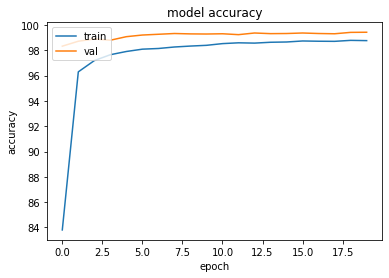

In [7]:
_= plt.plot(acc_history)
_= plt.plot(val_acc_history)
_= plt.title('model accuracy')
_= plt.ylabel('accuracy')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

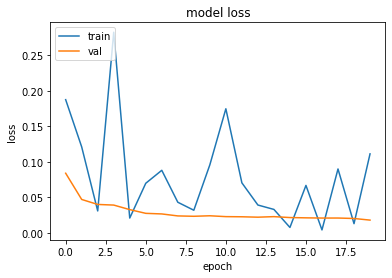

In [8]:
_= plt.plot(loss_history)
_= plt.plot(val_loss_history)
_= plt.title('model loss')
_= plt.ylabel('loss')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

- Total params:  14,112 (which is expected,given higher NW capacity) & the max validation accuracy reaches: ~99.42% 

- This case meets the required goal of getting an accuracy of 99.4% (appeared 2 times during training-epochs), the parameters: 14,112 < 20K (requirement) and came under 20 epochs.